In [ ]:
#default_exp core

In [ ]:
#hide
from nbdev.showdoc import show_doc

# Core
> Core modules of this library.

In [ ]:
#export
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torchvision.transforms import ToTensor
from skimage.feature import peak_local_max

## Utility Functions

In [ ]:

#export
def expand_dim_to_3(arr):
    if arr.ndim == 2:
        return np.expand_dims(arr, axis=-1)
    elif arr.ndim == 3:
        return arr
    else:
        raise ValueError()
    
def parametric_ellipse(alpha, A, a, b):
    X = a * np.cos(alpha) * np.cos(A) - b * np.sin(alpha) * np.sin(A)
    Y = a * np.cos(alpha) * np.sin(A) + b * np.sin(alpha) * np.cos(A)
    return X, Y

def elliplise(axes, angle, center=None, width=None, height=None):
    a = axes[0]
    b = axes[1]
    
    A = np.deg2rad(angle)
    cc = [parametric_ellipse(alpha, A, a, b) for alpha in np.linspace(0, np.pi*2, 1000)]

    if height is None and width is None:
        width, height = np.max(cc, axis=0)
        width = round(width) * 2 + 1
        height = round(height) * 2 + 1

    if center is None:
        center = (round(width/2), round(height/2))
    
    mask = np.zeros((height, width), np.uint8) 
    template = torch.Tensor(cv.ellipse(mask, center, axes, angle, color=1, thickness=-1, startAngle=0, endAngle=360)).unsqueeze(0)
    return template


In [ ]:
#export

class EllipticalSeparabilityFilter:
    def __init__(self, axes_in, axes_out, angle):
        self.axes_in = axes_in
        self.axes_out = axes_out
        self.angle = angle
        
        inner_region, outer_region, full_region = self.ellipse_templates()
        self.inner_region = inner_region
        self.outer_region = outer_region
        self.full_region = full_region
        
    def __call__(self, img):
        axes_in, axes_out, angle = self.axes_in, self.axes_out, self.angle
        inner_region, outer_region, full_region = self.inner_region, self.outer_region, self.full_region
        
        top = bottom = axes_out[0]
        right = left = axes_out[1]
        borderType = cv.BORDER_REPLICATE
        img = cv.copyMakeBorder(img, top, bottom, left, right, borderType)

        img = ToTensor()(img)
        c = img.shape[0]
        img = img.unsqueeze(0)

        n_inner = inner_region.sum()
        n_outer = outer_region.sum()
        n_full = n_inner + n_outer

        w_inner = inner_region.repeat([c,1,1,1]) / n_inner
        w_outer = outer_region.repeat([c,1,1,1]) / n_outer
        w_full = full_region.repeat([c,1,1,1]) / n_full

        m_inner = torch.nn.functional.conv2d(img, w_inner, groups=c)[0]
        m_outer = torch.nn.functional.conv2d(img, w_outer, groups=c)[0]
        m_full = torch.nn.functional.conv2d(img, w_full, groups=c)[0]

        sb_map = n_inner * (m_inner - m_full)**2 + n_outer * (m_outer - m_full)**2

        unfolded = torch.nn.functional.unfold(img.permute((1,0,2,3)), w_full.shape[-2:])
        meansubbed = unfolded - m_full.reshape(c, 1, -1)
        squared = meansubbed ** 2
        st_map = (w_full.reshape(c, 1, -1) @ squared).reshape(sb_map.shape[-3:])

        out = sb_map / st_map
        return out.mean(axis=0, keepdim=True)
    
    def ellipse_templates(self):
        axes_in, axes_out, angle = self.axes_in, self.axes_out, self.angle
        full_region = elliplise(axes_out, angle)

        height, width = full_region.shape[1:]
        inner_region = elliplise(axes=axes_in, angle=angle, height=height, width=width)

        outer_region = full_region - inner_region

        return inner_region, outer_region, full_region
    
    def find_circles(self, img, num_circles=None):
        sepmap = self.__call__(img).numpy().squeeze().T
        sepmap[np.isnan(sepmap)]=0
        peaks = peak_local_max(sepmap)
        
        if num_circles is None:
            return peaks
        else:
            return peaks[:num_circles] 
            

In [ ]:
show_doc(EllipticalSeparabilityFilter.find_circles)

<h4 id="EllipticalSeparabilityFilter.find_circles" class="doc_header"><code>EllipticalSeparabilityFilter.find_circles</code><a href="__main__.py#L60" class="source_link" style="float:right">[source]</a></h4>

> <code>EllipticalSeparabilityFilter.find_circles</code>(**`img`**, **`num_circles`**=*`None`*)



## Usage Example

In [ ]:
#hide
# plotting functions

def torch2numpy(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

def show(img):
    img = torch2numpy(img) if isinstance(img, torch.Tensor) else img
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    
%matplotlib inline
def plot_images(imgs):
    fig, axs = plt.subplots(ncols=len(imgs))
    for i, img in enumerate(imgs):
        ax = axs[i]
        img = torch2numpy(img) if isinstance(img, torch.Tensor) else img
        ax.imshow(img, interpolation='nearest')
        ax.axis('off')
    plt.show()

Given an image of persons face, we may want to detect the region of that persons eyes (I've hidden the definition of some plotting functions such as `show` and `plot_images` for readability).

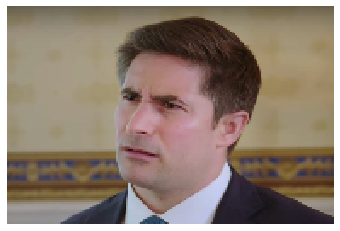

In [ ]:
img = cv.cvtColor(cv.imread('../images/face.jpeg'), cv.COLOR_BGR2RGB)
img = cv.resize(img, (192, 128))
show(img)

For such an image, it is useful to have a template filter that matches the size of the eye. 
Templates sizes can be determined by manual tuning or automated search algorithms. Below is an example of an appropriate template.

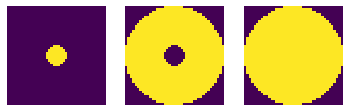

In [ ]:
esf = EllipticalSeparabilityFilter(axes_in=(4,4), axes_out=(20,20),angle=0)
plot_images(esf.ellipse_templates())

Using this template we can caluclate a separability map from the image.

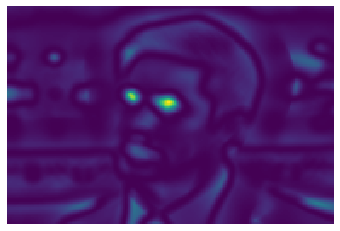

In [ ]:
sepmap = esf(img)
show(sepmap)

Using the `find_circles` function, we can find a number of circles in the image.

[[95 56]
 [72 52]]


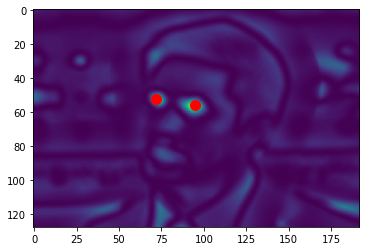

In [ ]:
points = esf.find_circles(img, num_circles=2)
print(points)

plt.imshow(sepmap.squeeze())
plt.scatter(*points.T, color='red', s=100) 

## Other examples

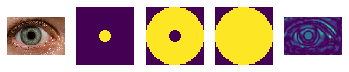

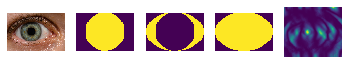

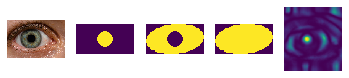

In [ ]:
img = cv.cvtColor(cv.imread('../images/eye.png'), cv.COLOR_BGR2RGB)
img = cv.resize(img, (192, 128))

esf = EllipticalSeparabilityFilter(axes_in=(4,4), axes_out=(20,20),angle=0)
sepmap = esf(img)
plot_images([img, *esf.ellipse_templates(), sepmap])

esf = EllipticalSeparabilityFilter(axes_in=(20,20), axes_out=(30,20),angle=0)
sepmap = esf(img)
plot_images([img, *esf.ellipse_templates(), sepmap])

esf = EllipticalSeparabilityFilter(axes_in=(10,10), axes_out=(40,20),angle=-5)
sepmap = esf(img)
plot_images([img, *esf.ellipse_templates(), sepmap])

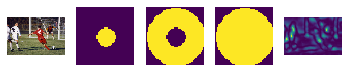

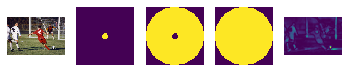

In [ ]:
img = cv.cvtColor(cv.imread('../images/football.jpg'), cv.COLOR_BGR2RGB)
img = cv.resize(img, (192, 128))

esf = EllipticalSeparabilityFilter(axes_in=(8,8), axes_out=(25,25),angle=0)
sepmap = esf(img)
plot_images([img, *esf.ellipse_templates(), sepmap])

esf = EllipticalSeparabilityFilter(axes_in=(3,3), axes_out=(40,40),angle=0)
sepmap = esf(img)
plot_images([img, *esf.ellipse_templates(), sepmap])